In [1]:
import os, sys
# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import time
import jax.numpy as jnp
import scs
import numpy as np
from scipy.sparse import csc_matrix
from l2ws.algo_steps import k_steps_eval_osqp, k_steps_train_osqp, create_projection_fn, lin_sys_solve, k_steps_train_osqp
import jax.scipy as jsp
import pytest
import matplotlib.pyplot as plt
from l2ws.osqp_model import OSQPmodel
import cvxpy as cp
from jax import vmap
from functools import partial
from examples.osc_mass import multiple_random_osc_mass_osqp
from examples.mpc import multiple_random_mpc_osqp, solve_many_probs_cvxpy, solve_multiple_trajectories
from scipy.spatial import distance_matrix
# from examples.ista import sol_2_obj_diff, solve_many_probs_cvxpy
from l2ws.utils.nn_utils import get_nearest_neighbors

/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
N_train = 500
N_test = 100
N = N_train + N_test
T = 10
num_traj = 10
x_init_factor = .3
factor, P, A, q_mat_train, theta_mat_train, x_bar, Ad = multiple_random_mpc_osqp(N_train, 
                                                            T=T,
                                                            nx=10,
                                                            nu=5,
                                                            sigma=1,
                                                            rho=1,
                                                            Ad=None,
                                                            Bd=None,
                                                            seed=42,
                                                            x_init_factor=x_init_factor)
# train_inputs, test_inputs = theta_mat[:N_train, :], theta_mat[N_train:, :]
# z_stars_train, z_stars_test = None, None
# q_mat_train, q_mat_test = q_mat[:N_train, :], q_mat[N_train:, :]
q = q_mat_train[0, :]
theta_mat_test, z_stars_test, q_mat_test = solve_multiple_trajectories(T, num_traj, x_bar, x_init_factor, Ad, P, A, q)

# create theta_mat and q_mat
q_mat = jnp.vstack([q_mat_train, q_mat_test])
theta_mat = jnp.vstack([theta_mat_train, theta_mat_test])

# solve the QPs
z_stars, objvals = solve_many_probs_cvxpy(P, A, q_mat)
z_stars_train, z_stars_test = z_stars[:N_train, :], z_stars[N_train:, :]

train_unrolls = 10
input_dict = dict(algorithm='osqp',
                    q_mat_train=q_mat_train,
                    q_mat_test=q_mat_test,
                    A=A,
                    factor=factor,
                    train_inputs=theta_mat[:N_train, :],
                    test_inputs=theta_mat[N_train:, :],
                    train_unrolls=train_unrolls,
                    nn_cfg={'intermediate_layer_sizes': [300]},
                    jit=True)
osqp_model = OSQPmodel(input_dict)


finished solving cvxpy problems


In [4]:
train_inputs, test_inputs = theta_mat_train, theta_mat_test

# full evaluation on the test set with nearest neighbor
k = 1000
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = osqp_model.evaluate(k, nearest_neighbors_z,
                                    q_mat_test, z_stars=z_stars_test,
                                    fixed_ws=True, tag='test')
nn_losses = nn_eval_out[1][1].mean(axis=0)
print('train_inputs', train_inputs.shape)
print('test_inputs', test_inputs.shape)
print('nearest_neighbors_z', nearest_neighbors_z.shape)
print('q_mat_test', q_mat_test.shape)


distances [[1.06493963 1.41291272 1.18942571 ... 1.32197421 1.12481809 0.91419763]
 [1.0926024  0.92904175 1.13679083 ... 0.89736154 0.95422683 0.80127052]
 [0.78761343 1.3819401  1.03772069 ... 1.19102692 0.80255289 0.92168479]
 ...
 [1.03499653 0.96059884 1.14681159 ... 0.85460053 0.92945072 0.65642238]
 [0.69940077 1.19482725 0.90549916 ... 1.04563368 0.69783864 0.81172793]
 [1.02139279 0.97540519 1.13942875 ... 0.85785505 0.91113537 0.64244695]]
indices [114  60 323 483 406 483 406 483 406 483 443  60 411 483 406 483 139 483
 139 181  78 425 425 483 425 282 425 425 425 425  38 406 282  91 282 425
 282 425 282 425 185 203 425 425 425 425 425 425 425 425 112 235 223 425
 170 425 425 425 425 425 289 215 282  91 282 323 483 323 483 323 411  60
 411 483 406 483 406 483 406 483 334 282 165 282 425 282 425 282 425 282
  71 483 323 282 323 483 323 483 323 483]
best val [0.51472543 0.49213432 0.45168723 0.37059034 0.39363042 0.39344721
 0.35572681 0.40761324 0.35218959 0.4035189  0.52999388

In [6]:
# full evaluation on the test set with prev solution
non_first_indices = jnp.mod(jnp.arange(N_test), num_traj) != 0
non_last_indices = jnp.mod(jnp.arange(N_test), num_traj) != N_test.size - 1
print('non_first_indices', non_first_indices.shape)
q_mat_prev = q_mat_test[non_first_indices, :]
prev_z = z_stars_test[non_last_indices, :]
prev_sol_out = osqp_model.evaluate(k, prev_z,
                                    q_mat_prev, z_stars=None,
                                    fixed_ws=True, tag='test')
prev_sol_losses = nn_eval_out[1][1].mean(axis=0)




non_first_indices (65000,)


IndexError: boolean index did not match shape of indexed array in index 0: got (65000,), expected (100,)

In [ ]:
# full evaluation on the test set with cold-start
init_eval_out = osqp_model.evaluate(
    k, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)

plt.plot(init_test_losses)
plt.plot(prev_sol_losses)
plt.plot(nn_losses)
plt.yscale('log')
plt.show()

In [9]:
dists = jnp.linalg.norm(z_stars, axis=1)
print(dists.shape)
print(z_stars.shape)
print(dists)

(550,)
(550, 400)
[1.60613855 2.685297   1.79263197 1.76734633 1.7988617  1.15995126
 1.69378274 0.85129111 1.46679957 1.67961118 2.11722395 1.63122413
 2.05358742 1.27707695 2.18335559 1.14917533 1.53382396 1.74566109
 2.0218169  1.69020522 1.23007152 1.79673721 1.57761824 2.03404156
 1.33152788 1.72654745 2.54186807 1.26223972 2.87023352 2.55570007
 1.7444235  1.31097703 1.23599624 2.35808192 0.88675855 1.87578049
 2.18209209 1.93136477 1.33521877 1.98191133 1.43090587 1.61555725
 1.09923856 1.47398331 1.8977167  1.75461024 1.51850944 1.09519391
 1.25691588 1.72354594 1.59728217 0.86643277 2.03642779 2.16153159
 1.3217543  0.84534116 1.98379448 1.6863314  2.41087684 0.99111103
 2.1576588  1.81655129 1.28934565 1.46599724 2.20923834 1.88385784
 1.63448839 1.76441876 0.74857616 1.85573462 1.27426007 1.43911311
 1.46211039 1.71394408 1.52667361 1.75821989 0.61895715 1.8503654
 1.4895768  1.74940475 1.86672097 1.85981305 1.90942244 1.15834565
 2.43892067 2.05025301 1.27460578 1.27922632 

In [11]:
# train the osqp_model
# call train_batch without jitting
params, state = osqp_model.params, osqp_model.state
num_epochs = 1000
train_losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = osqp_model.train_full_batch(params, state)
    loss, params, state = train_result
    train_losses = train_losses.at[i].set(loss)

osqp_model.params, osqp_model.state = params, state

# full evaluation on the test set
# k = 200
final_eval_out = osqp_model.evaluate(
    k, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_test_losses = final_eval_out[1][1].mean(axis=0)
# final_z_all = init_eval_out[1][3]

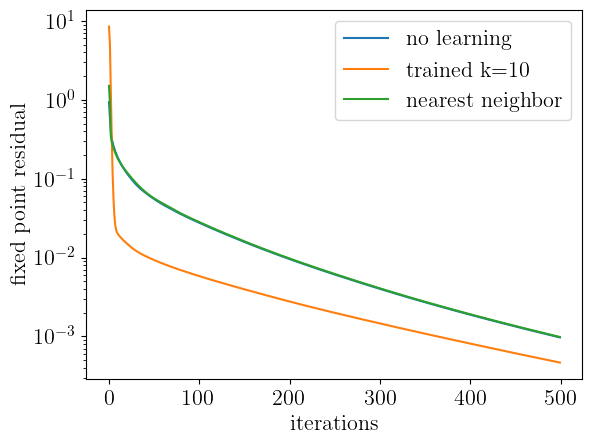

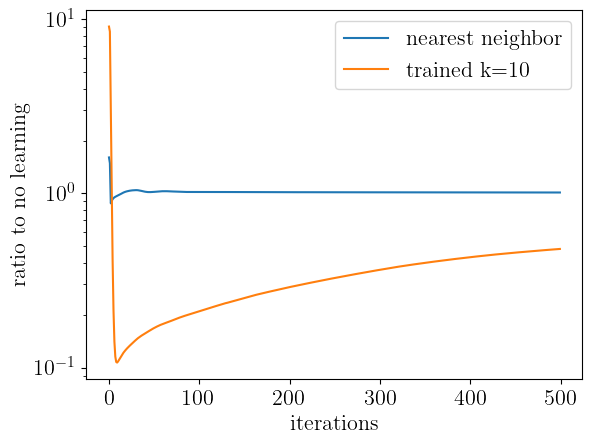

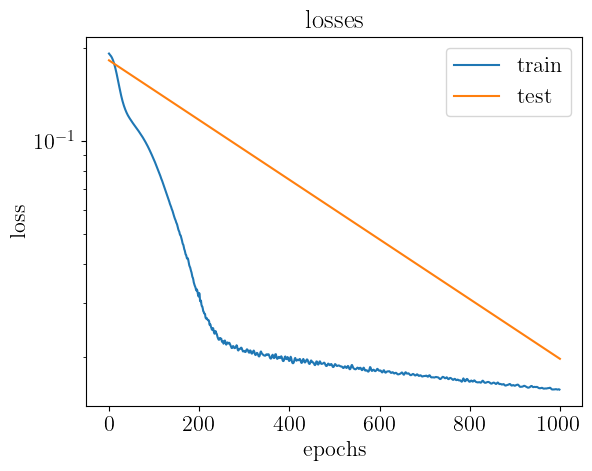

In [17]:
plt.plot(init_test_losses[:500], label='no learning')
plt.plot(final_test_losses[:500], label=f"trained k={train_unrolls}")
plt.plot(nn_losses[:500], label='nearest neighbor')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('fixed point residual')
plt.legend()
plt.show()

plt.plot(nn_losses[:500] / init_test_losses[:500], label='nearest neighbor')
plt.plot(final_test_losses[:500] / init_test_losses[:500], label=f"trained k={train_unrolls}")
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('ratio to no learning')
plt.legend()
plt.show()

plt.title('losses')
plt.plot(train_losses, label='train')
init_test_loss = init_test_losses[train_unrolls]
final_test_loss = final_test_losses[train_unrolls]
test_losses = np.array([init_test_loss, final_test_loss])
epochs_array = np.array([0, num_epochs])
plt.plot(epochs_array, test_losses, label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()